In [1]:
import sys
sys.path.append("..")

import numpy as np
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 90

from src.dataset import Dataset
from src.vectorizers import TokenVectorizer

In [2]:
dataset = Dataset()
dates = dataset.load_dataset(year=None, dates=True, courts={"Illinois Appellate Court"})

In [3]:
vectors, vectorizer = TokenVectorizer.load_vectors_vectorizer(method="count")

In [4]:
print(f"Vocabulary length: {len(vectorizer.vocabulary_)}")

Vocabulary length: 38855


In [22]:
vocab = vectorizer.get_feature_names()
word2id = dict((v, idx) for idx, v in enumerate(vocab))
id2word = dict((idx, v) for idx, v in enumerate(vocab))

vectors_trans = vectors.transpose()

In [37]:
intervals = 5
norm_dates = [e - e%intervals for e in dates]

dates_frequencies = defaultdict(lambda:0)

for d in norm_dates:
    dates_frequencies[d] += 1

In [38]:
def get_distribution(term, word2id, doc_dates, transposed_vectors, dates_frequencies, low_filter=-1):
    ind = word2id.get(term, -1)
    if ind < 0:
        return []
    docs = [(index, 1) for index, occ in 
            enumerate(transposed_vectors[ind].toarray()[0]) if occ > 0]
    
    dates = [(doc_dates[index], occ) for index, occ in docs]
    freqs = defaultdict(lambda:0)
    for year, occ in dates:
        freqs[year] += occ
            
    return sorted([(year, occ/dates_frequencies[year]) 
                   for year, occ in freqs.items() if year > low_filter])

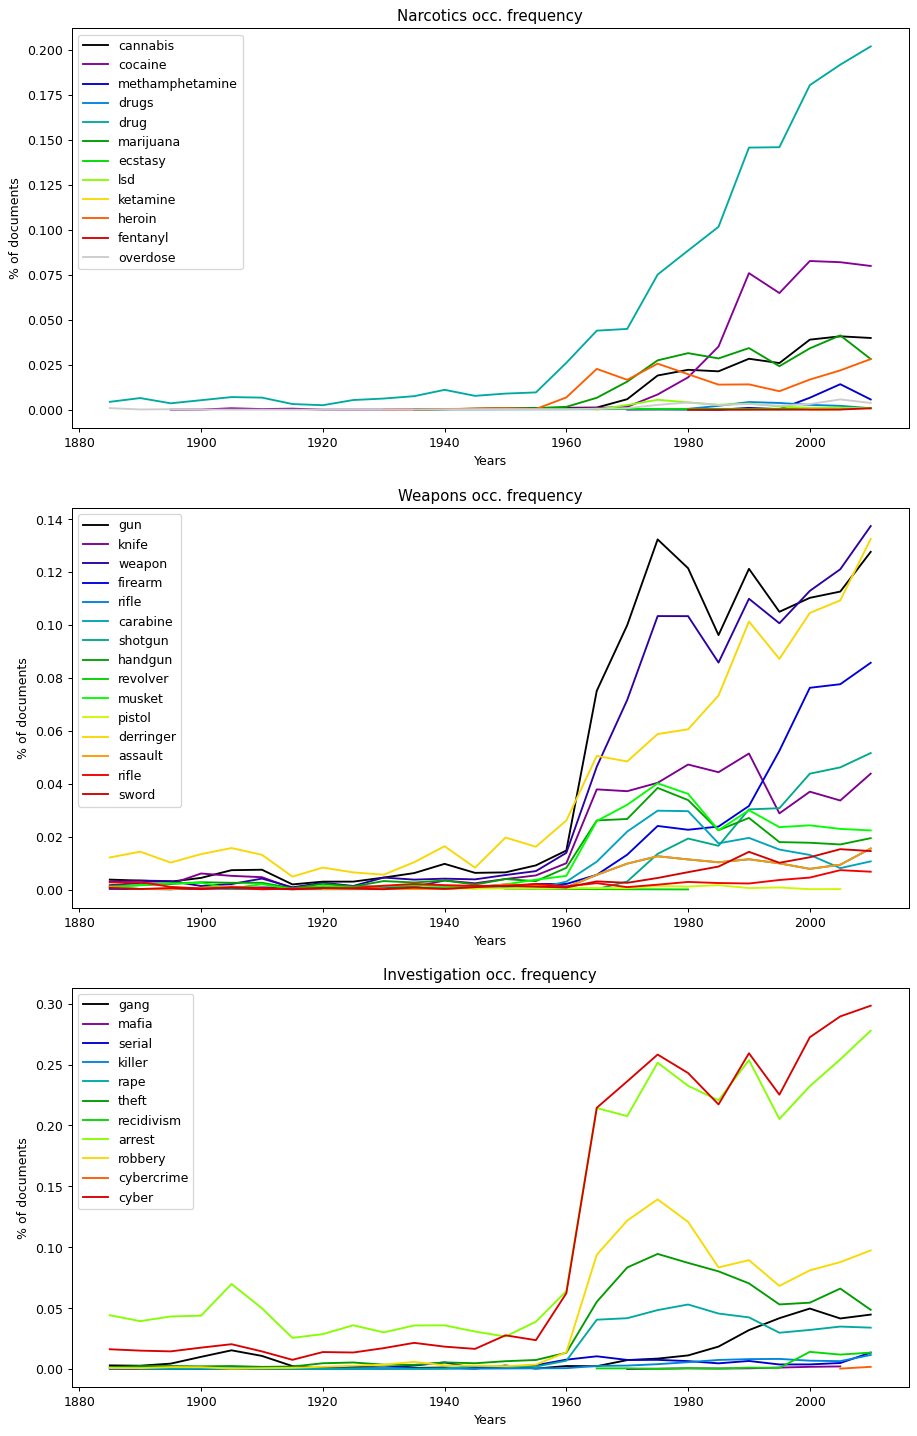

In [41]:

narcotics = ['cannabis', 'cocaine', 'methamphetamine', 'drugs', 'drug', 'marijuana', 
             'ecstasy', 'lsd', 'ketamine', 'heroin', 'fentanyl', 'overdose']

weapons = ['gun', 'knife', 'weapon', 'firearm', 'rifle', 'carabine', 'shotgun', 'handgun', 
           'revolver', 'musket', 'pistol', 'derringer', 'assault', 'rifle', 'sword', 'blunt']

investigation = ['gang', 'mafia', 'serial',  'killer', 'rape', 'theft', 'recidivism', 
                 'arrest', 'robbery', 'cybercrime', 'cyber', 'crime']

titles = ["Narcotics", "Weapons", "Investigation"]

fig, axs = plt.subplots(3,1, figsize=(12,20))

colormap = plt.cm.nipy_spectral

for i, words in enumerate([narcotics, weapons, investigation]):
    
    colors = [colormap(i) for i in np.linspace(0, 1,len(words))]
    axs[i].set_prop_cycle('color', colors)
    
    for word in words:
    
        dist = get_distribution(word, word2id, norm_dates, vectors_trans, dates_frequencies, low_filter=1880)
        if not dist:
            continue
    
        x = [e[0] for e in dist]
        y = [e[1] for e in dist]
        axs[i].set(title=f"{titles[i]} occ. frequency", xlabel="Years", ylabel="% of documents")
        axs[i].plot(x, y)
        axs[i].legend(words)
        
plt.savefig("../data/images/interesting_words_occ.jpeg", dpi=300)
plt.show()